<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

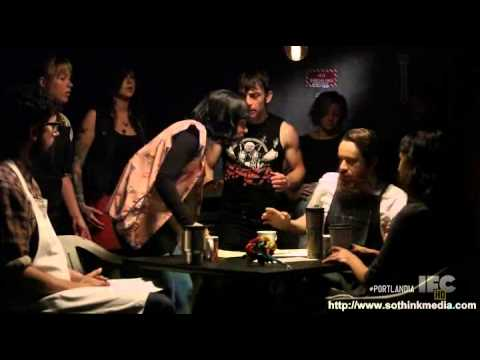

In [2]:
# Testing git
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [3]:
%pwd

'C:\\Users\\coope\\OneDrive\\Desktop\\Unit4\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [98]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)

In [99]:
""" DATA CLEANING """

import re

# Seperating data from review
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.strip())
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.split(" ", 1))

# standardizing/creating
shops['date'] = shops['full_review_text'].apply(lambda x: x[0])
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: re.sub('[^a-zA-Z 0-9]', '', x[1].lower()))

# Grabbing and casting the star rating
shops['star_rating'] = shops['star_rating'].apply(lambda x: int(x[0:2]))

# Inspecting
shops.head(2)

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,1 checkin love love loved the atmosphere every...,5,11/25/2016
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in austin...,4,12/2/2016


In [100]:
# Further inspection
shops.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
coffee_shop_name,7616,79,Epoch Coffee,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
full_review_text,7616,6915,the factory is gonna be my new coffee spot no ...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
star_rating,7616,NaN,NaN,NaN,4.16912,1.06531,1,4,4,5,5
date,7616,1592,10/9/2016,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
shops['star_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: star_rating, dtype: int64

In [102]:
""" TOKENIZING USING SPACY """

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [103]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [104]:
# Applying the tokenizer
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [105]:
# Count Function to count tokens
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [106]:
wc = count(shops['tokens'])
wc

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
9,,4831,18226,1.0,0.047003,0.047003,0.634322
12,coffee,4877,10353,2.0,0.026699,0.073702,0.640362
98,place,3659,5426,3.0,0.013993,0.087695,0.480436
152,good,2788,3973,4.0,0.010246,0.097941,0.366071
93,great,2836,3919,5.0,0.010107,0.108047,0.372374
...,...,...,...,...,...,...,...
20251,roomier,1,1,20253.0,0.000003,0.999990,0.000131
20252,windowed,1,1,20254.0,0.000003,0.999992,0.000131
20253,actuality,1,1,20255.0,0.000003,0.999995,0.000131
20254,crass,1,1,20256.0,0.000003,0.999997,0.000131


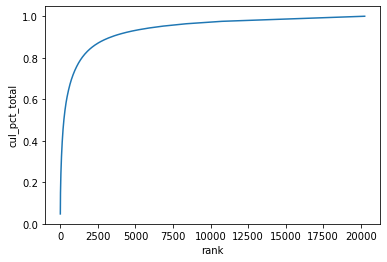

In [107]:
# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

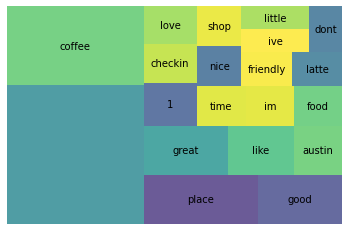

In [108]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.show()

In [112]:
# Expanding the stopwords list
additional_stop_words = ['1', "im", 'coffee', 'got', "ive", "dont", "like", "its", 'austin', '-', " "]
STOP_WORDS = nlp.Defaults.stop_words.union(additional_stop_words)

In [113]:
# Applying the stopwords (removing them from tokens)
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

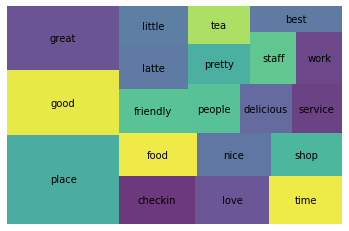

In [114]:
wc = count(shops['tokens'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [121]:
""" CREATE LEMMATIZATION COLUMN """
nlp = spacy.load("en_core_web_lg")

In [122]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [ ]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [ ]:
shops

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [ ]:
"""
Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques:

Lemmatization
Custom stopword removal
Keep in mind the attributes of good tokens.
Once you have a solid baseline, layer in the star rating in your visualization(s).
Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst.
Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells!
"""

In [94]:
shops

,coffee_shop_name,full_review_text,star_rating,date,tokens
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5,11/25/2016,"[check-in, love, love, loved, atmosphere!, cor..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4,12/2/2016,"[listed, date, night:, austin,, ambiance, beau..."
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4,11/30/2016,"[check-in, listed, brunch, spots, loved, eclec..."
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2,11/25/2016,"[cool, decor!, good, drinks, nice, seating, ho..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4,12/3/2016,"[check-in, located, northcross, mall, shopping..."
...,...,...,...,...,...
7611,The Steeping Room,I actually step into this restaurant by chance...,4,2/19/2015,"[actually, step, restaurant, chance, favorites..."
7612,The Steeping Room,"Ok, The Steeping Room IS awesome. How do they ...",5,1/21/2016,"[ok,, steeping, room, awesome., great, menu, i..."
7613,The Steeping Room,"Loved coming here for tea, and the atmosphere ...",4,4/30/2015,"[loved, coming, tea,, atmosphere, pretty, fres..."
7614,The Steeping Room,The food is just average. The booths didn't fe...,3,8/2/2015,"[food, average., booths, didn't, feel, clean.,..."


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

